# Set up

In [55]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import *
from tensorflow.keras.metrics import *
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

In [32]:
import os
print(os.getcwd())
train_path = os.getcwd() + '/cats-and-dogs/train'
valid_path = os.getcwd() + '/cats-and-dogs/valid'
test_path = os.getcwd() + '/cats-and-dogs/test'

/Users/ernestang98/Desktop/github/ernie/self-taught-things/dsai/Keras - DL Tutorial/CNN


In [121]:
# https://kylewbanks.com/blog/loading-unlabeled-images-with-imagedatagenerator-flowfromdirectory-keras
# https://datascience.stackexchange.com/questions/51671/keras-flow-from-directory-returns-0-images

train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(224,224), batch_size=10)
valid_batches = ImageDataGenerator().flow_from_directory(valid_path, target_size=(224,224), batch_size=10)
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(224,224), batch_size=10)

Found 12500 images belonging to 2 classes.
Found 12500 images belonging to 2 classes.
Found 28 images belonging to 2 classes.


In [88]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [89]:
imgs, labels = next(train_batches)

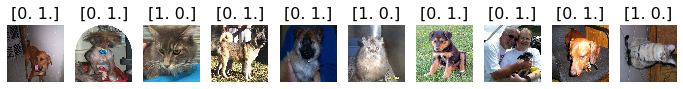

In [90]:
plots(imgs, titles=labels)

# Build and train CNN

In [113]:
model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(224,224,3)),
        Flatten(),
        Dense(2, activation='softmax'),
    ])

In [114]:
model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [115]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
flatten_3 (Flatten)          (None, 1577088)           0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 3154178   
Total params: 3,155,074
Trainable params: 3,155,074
Non-trainable params: 0
_________________________________________________________________


In [116]:
# performance pretty bad

model.fit_generator(train_batches, steps_per_epoch=4, 
                    validation_data=valid_batches, validation_steps=4, epochs=5, verbose=2)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 4 steps, validate for 4 steps
Epoch 1/5
4/4 - 2s - loss: 1126.4830 - accuracy: 0.4750 - val_loss: 660.8295 - val_accuracy: 0.4500
Epoch 2/5
4/4 - 1s - loss: 658.5074 - accuracy: 0.4750 - val_loss: 697.7295 - val_accuracy: 0.5500
Epoch 3/5
4/4 - 1s - loss: 657.3564 - accuracy: 0.4000 - val_loss: 533.5795 - val_accuracy: 0.4500
Epoch 4/5
4/4 - 1s - loss: 119.3539 - accuracy: 0.5750 - val_loss: 158.4291 - val_accuracy: 0.5750
Epoch 5/5
4/4 - 1s - loss: 229.6436 - accuracy: 0.4250 - val_loss: 149.6673 - val_accuracy: 0.6000


# Predict

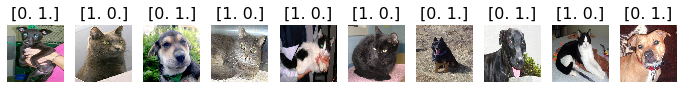

In [123]:
test_imgs, test_labels = next(test_batches)
plots(test_imgs, titles=test_labels)

In [124]:
test_labels = test_labels[:,0]
test_labels

array([0., 1., 0., 1., 1., 1., 0., 0., 1., 0.], dtype=float32)

In [125]:
predictions = model.predict_generator(test_batches, steps=1, verbose=0)

In [126]:
predictions

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [127]:
cm = confusion_matrix(test_labels, predictions[:,0])

In [128]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1 4]
 [1 4]]


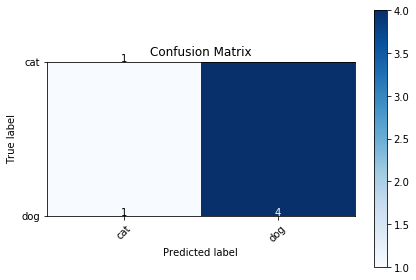

In [129]:
cm_plot_labels = ['cat','dog']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

## Build Fine-tuned VGG16 model

In [102]:
vgg16_model = keras.applications.vgg16.VGG16()

553467904/553467096 [==============================] - 425s 1us/step


In [148]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [149]:
type(vgg16_model)

tensorflow.python.keras.engine.training.Model

In [150]:
model = Sequential()
for layer in vgg16_model.layers:
    model.add(layer)

In [151]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [152]:
model.layers.pop()

In [153]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [154]:
for layer in model.layers:
    layer.trainable = False

In [155]:
model.add(Dense(2, activation='softmax'))

In [156]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

## Train the fine-tuned VGG16 model

In [162]:
model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [163]:
model.fit_generator(train_batches, steps_per_epoch=4, 
                    validation_data=valid_batches, validation_steps=4, epochs=15, verbose=2)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 4 steps, validate for 4 steps
Epoch 1/15
4/4 - 37s - loss: 0.6959 - accuracy: 0.3750 - val_loss: 0.6913 - val_accuracy: 0.3250
Epoch 2/15
4/4 - 34s - loss: 0.6889 - accuracy: 0.5750 - val_loss: 0.6911 - val_accuracy: 0.4000
Epoch 3/15
4/4 - 35s - loss: 0.6894 - accuracy: 0.4500 - val_loss: 0.6909 - val_accuracy: 0.4000
Epoch 4/15
4/4 - 36s - loss: 0.6899 - accuracy: 0.5000 - val_loss: 0.6907 - val_accuracy: 0.4000
Epoch 5/15
4/4 - 34s - loss: 0.6917 - accuracy: 0.6250 - val_loss: 0.6906 - val_accuracy: 0.4250
Epoch 6/15
4/4 - 37s - loss: 0.6854 - accuracy: 0.6750 - val_loss: 0.6905 - val_accuracy: 0.4500
Epoch 7/15
4/4 - 36s - loss: 0.6837 - accuracy: 0.6250 - val_loss: 0.6903 - val_accuracy: 0.4500
Epoch 8/15
4/4 - 38s - loss: 0.6878 - accuracy: 0.6000 - val_loss: 0.6902 - val_accuracy: 0.4500
Epoch 9/15
4/4 - 37s - loss: 0.6893 - accuracy: 0.5000 - val_loss: 0.6901 - val_accuracy: 0.4500
Epoch 10/15
4/4 - 37s - loss: 0.6901 

If saving this model with model.save('file.h5'), note that some users have reported the following error when loading the model using load_model('file.h5'):
    
ValueError: Dimension 0 in both shapes must be equal, but are 4096 and 1000.
Shapes are [4096,10] and [1000,10]. for 'Assign_61' (op: 'Assign') with input shapes: [4096,10], [1000,10].
   
If you receive this error, please see the answer in this stackoverflow post:
https://stackoverflow.com/questions/48482483/valueerror-when-loading-a-previously-saved-retrained-vgg16-model-using-keras

## Predict using fine-tuned VGG16 model

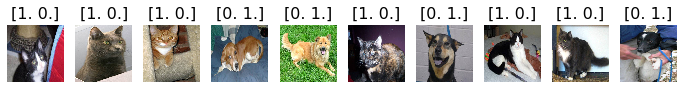

In [168]:
test_imgs, test_labels = next(test_batches)
plots(test_imgs, titles=test_labels)

In [169]:
test_labels = test_labels[:,0]
test_labels

array([1., 1., 1., 0., 0., 1., 0., 1., 1., 0.], dtype=float32)

In [170]:
predictions = model.predict_generator(test_batches, steps=1, verbose=0)

In [171]:
cm = confusion_matrix(test_labels, np.round(predictions[:,0]))

Confusion matrix, without normalization
[[2 2]
 [1 5]]


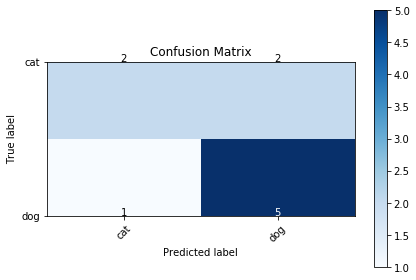

In [172]:
cm_plot_labels = ['cat','dog']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')